<a href="https://colab.research.google.com/github/Husam94/poseydon-chisel/blob/master/Mini_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The following is the Case Study 1.1.**  
**Google Colab Edition**  
This is a combination of Parts A and B but uses less memory and computation resource for use on Google Colab.  
Due to memory constraints, variables are deleted and reloaded at different times.  

Install Chisel and restart runtime

In [ ]:
!pip install poseydon-chisel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 7.6 MB/s 
     |████████████████████████████████| 64 kB 3.8 MB/s 
     |████████████████████████████████| 2.3 MB 37.3 MB/s 
     |████████████████████████████████| 11.2 MB 47.8 MB/s 
     |████████████████████████████████| 420 kB 69.7 MB/s 
     |████████████████████████████████| 959 kB 62.2 MB/s 
  Created wheel for poseydon-chisel: filename=poseydon_chisel-0.0.3-py3-none-any.whl size=10973 sha256=2d7307433c3ac9bb935670ccf6067b9f828c7edf15979446a71dcb399086b306
  Stored in directory: /root/.cache/pip/wheels/d5/af/30/b3da35a0017d7b9bd4cb9f7a488d429f876342ba1150281554
  Created wheel for pybigwig: filename=pyBigWig-0.3.18-cp37-cp37m-linux_x86_64.whl size=197544 sha256=9f90c5dd85a76d531ab57d24fd48605b4c9abd9ed51502ae413350cfc23040b8
  Stored in directory: /root/.cache/pip/wheels/28/eb/46/c761563ba38bd516bcc6accde3d4188cd84eec067f9201cbec
Succe

## Launch

In [2]:
from poseydon_chisel import * 

In [3]:
import pandas as pd
import numpy as np
import pickle

from scipy import stats

In [4]:
import urllib.request
from tqdm import tqdm

#https://stackoverflow.com/questions/15644964/python-progress-bar-and-downloads

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

### Global Variables

Set these based on computing resources.  
The defaults work well on google colab but may be expanded.  
Only 2 of the 11 histones are used, only chromosome 3, and most CurrentTracks are at a 100bp resolution. 

In [5]:
histones = ['H3K4me3', 'H3K27ac']
select_chrs = ['chr3']
CTReso = 100 #resolution of CurrentTracks (when appropriate)
fontsize = 12

## Part A

Download necessary pre-made files from GitHub

In [ ]:
bank = 'https://raw.githubusercontent.com/Husam94/poseydon-chisel/master/docs/'
bank_files = ['hg38-blacklist.v2.bed', 'YY1_summits_toppeaks.bed', 'YY1_CM.txt', 'Dataset_Identifiers.txt']

for bf in bank_files:
    download_url(bank+bf, bf)

hg38-blacklist.v2.bed: 32.8kB [00:00, 185kB/s]                             
YY1_summits_toppeaks.bed: 147kB [00:00, 500kB/s]                             
YY1_CM.txt: 8.19kB [00:00, 47.3kB/s]
Dataset_Identifiers.txt: 8.19kB [00:00, 52.1kB/s]


In [ ]:
data_source = pd.read_csv('Dataset_Identifiers.txt', sep = '\t', header = 0)

In [ ]:
!mkdir bam

In [ ]:
path_A = 'https://www.encodeproject.org/files/'
path_B = '/@@download/'
path_C = '.bam'

for index, row in data_source.iterrows():
    if row['target'] in histones + ['YY1']: #Only downloading those select histones and YY1
        download_url(path_A + row['id'] + path_B + row['id'] + path_C, 'bam/' + row['newid'] + path_C)

ENCFF564SVK.bam: 298MB [00:07, 40.9MB/s]                           
ENCFF685PPQ.bam: 471MB [00:11, 39.4MB/s]                           
ENCFF121RHF.bam: 465MB [00:10, 43.4MB/s]                           
ENCFF907MNY.bam: 227MB [00:05, 40.3MB/s]                           
ENCFF158VHG.bam: 344MB [00:08, 42.6MB/s]                           
ENCFF821RKN.bam: 815MB [00:19, 41.4MB/s]                           


In [ ]:
#genome from https://www.encodeproject.org/data-standards/reference-sequences/
genome_url = 'https://www.encodeproject.org/files/GRCh38_no_alt_analysis_set_GCA_000001405.15/@@download/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta.gz'
download_url(genome_url, 'hg38.fasta.gz')

GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta.gz: 873MB [00:18, 46.7MB/s]                           


In [ ]:
!gzip -d ./hg38.fasta.gz #unzip file 

## Part B

#### Human Genome

Creating a SeqCurrent from human genome fasta file. \
Only using the first 3 entries in the genome for sub-seqs. Loading only the first 3 to save memory. 

In [ ]:
hg38, hg38_id = Fasta2Seqs('hg38.fasta', idents = True, first = 3)
hg38_id = [c.split()[0] for c in hg38_id] #Simplifying ids 

hg38, hg38_id = [[x[ic] for ic, c in enumerate(hg38_id) if c in select_chrs] for x in [hg38, hg38_id]]

hg38_sizes = [len(c) for c in hg38] #Getting sizes

pickle.dump([hg38, hg38_id, hg38_sizes], open('hg38' + '.p', 'wb')) #Saving

In [ ]:
hg38_id, hg38_sizes

(['chr3'], [198295559])

In [ ]:
del [hg38]

#### Blacklist Regions

Importing Blacklist Regions bed file as Markers and converting to a BinCurrent.  
*See First_steps for pre-work*

In [ ]:
BLR = Bed2Markers('hg38-blacklist.v2.bed') 
BLR

,subseq,loc,strand,size
0,chr1,396250,0,792500
1,chr1,91387350,0,2100
2,chr1,103677500,0,166200
3,chr1,123272050,0,3333700
4,chr1,125076800,0,18400
...,...,...,...,...
631,chrY,4344800,0,2000
632,chrY,10643700,0,795000
633,chrY,11203700,0,263200
634,chrY,11622200,0,271200


Making inverse BinCurrent from Blacklist Markers (0s are bad regions)

In [ ]:
BLC = Markers2BinCurrent(BLR, hg38_sizes, hg38_id, select_BS_ids = select_chrs, 
                         Msizes = BLR.iloc[:, 3], reso = 1, inverse = True, dtype = np.int8) 

pickle.dump(BLC, open('BLC' + '.p', 'wb')) #Saving

Lowering resolution to NR and taking the minimum (0s are bad regions) 

In [ ]:
BLC_LR = LowerResCurrent(BLC, reso = 1, newreso = CTReso, resomode = np.min, dtype = np.int8) 

pickle.dump(BLC_LR, open('BLC_LR' + '.p', 'wb')) #Saving

In [ ]:
del [BLC, BLC_LR] #deleting 

### ChIP Signals

#### Histones

Making a dictionary of histone SigCurrents. Each entry is also a dictionary for the replicates. 

In [ ]:
histone_reps = {}
for h in histones: histone_reps[h] = {}

SigCurrents produced from bam alignment files. Reads are single-end and are extended to 300bp.  
*See First_steps for pre-work*

In [ ]:
for index, row in data_source[data_source['target'].isin(histones)].iterrows(): 
    target, rep, newid = row['target'], row['rep'], row['newid']
    histone_reps[target][rep] = Bam2Current('./bam/' + newid + '.bam', hg38_sizes, hg38_id, select_BS_ids = select_chrs, 
                                            newreso = CTReso, resomode = np.mean, stranded = False, read_length = 300, 
                                            paired = False, make_index = True, dtype = np.float32)

pickle.dump(histone_reps, open('histone_reps' + '.p', 'wb')) #Saving

Merging replicates by summing and storing in a new dictionary

In [ ]:
histone_merged = {}
for h in histone_reps.keys(): 
    histone_merged[h] = CurrentMerger(Currents2Current([histone_reps[h][e] for e in histone_reps[h].keys()]), mode = np.sum, dtype = np.float32) 

In [ ]:
del [histone_reps] #deleting

Combining all merged replicates into a single signal Current. 

In [ ]:
histone_combined = Currents2Current([histone_merged[h] for h in histone_merged.keys()])

pickle.dump(histone_combined, open('histone_combined' + '.p', 'wb')) #Saving

In [ ]:
del [histone_merged] #deleting

Zeroing signals in BLRs by multiplying Currents by CurrentModifier. BLC and BLC_LR, 0s are bad regions and 1s are good. 

In [ ]:
#histone_combined = pickle.load(open('histone_combined' + '.p', 'rb')) #loading

BLC_LR = pickle.load(open('BLC_LR' + '.p', 'rb')) #loading

histone_noBLR = CurrentModifier(histone_combined, BLC_LR, np.multiply) 

Min max normalizing values from 0 to max score for each signal in SigCurrent. 

In [ ]:
histone_norm = CurrentTransformer(histone_noBLR, minmax = (0, None), standardize = False, dtype = np.float32) 

pickle.dump(histone_norm, open('histone_norm' + '.p', 'wb')) #Saving

In [ ]:
del [histone_combined, BLC_LR, histone_noBLR] #deleting

#### Dead Regions

Getting a Dead region Current by windowing, thresholding, then padding.  
Dead region will be defined as not having any signal above 0.1 in a 2000bp window. 

In [ ]:
#histone_norm = pickle.load(open('histone_norm' + '.p', 'rb')) #loading

DC = CurrentWindower(histone_norm, reso = CTReso, mode = np.max, window = 2000, center = True, extend = True, dtype = np.float32) 
DC = CurrentThresholder(DC, threshold = 0.1, threshsign = np.greater, binary = True) #Windows not passing threshold have a 0
DC = CurrentPadder(DC, reso = CTReso, pad = 1000, shift = 0, value = 0, base = 1, dtype = np.int8) #Expanding 0s 1000bp each side to match initial 2000bp window

pickle.dump(DC,  open('DC' + '.p', 'wb')) #Saving

Merging Blacklist and Dead regions together to make a full filter Current (FT), aka a BadCurrent, keeping 0s in from both Currents by taking minumum. 

In [ ]:
#DC = pickle.load(open('DC' + '.p', 'rb')) #loading

BLC_LR = pickle.load(open('BLC_LR' + '.p', 'rb')) #loading

FT = CurrentMerger(Currents2Current([BLC_LR, DC]), mode = np.min) 

pickle.dump(FT, open('FT' + '.p', 'wb')) #Saving

Making bp resolution Dead region Current for later use. 

In [ ]:
#FT = pickle.load(open('FT' + '.p', 'rb')) #loading

FTE = CurrentExpander(FT, CTReso, hg38_sizes, hg38_id, select_BS_ids = select_chrs)

pickle.dump(FTE, open('FTE' + '.p', 'wb')) #Saving

In [ ]:
del [FTE] #deleting

Inverting so that 0s are good and 1s are bad for later use. 

In [ ]:
#FT = pickle.load(open('FT' + '.p', 'rb')) #loading

FTI = BinCurrentInverter(FT) 

pickle.dump(FTI, open('FTI' + '.p', 'wb')) #Saving

In [ ]:
del [FTI] #deleting

#### YY1

Like with histones previously, making a dictionary of YY1 replicates SigCurrents.  
SigCurrents produced from bam alignment files.  
*See First_steps for pre-work*

In [ ]:
YY1_reps = {}
for index, row in data_source[data_source['target'] == 'YY1'].iterrows(): 
    rep, newid = row['rep'], row['newid']
    YY1_reps[rep] = Bam2Current('./bam/' + newid + '.bam', hg38_sizes, hg38_id, select_BS_ids = select_chrs, 
                                newreso = CTReso, resomode = np.mean, stranded = False, read_length = 300, 
                                paired = False, make_index = True, dtype = np.float32)

pickle.dump(YY1_reps, open('YY1_reps' + '.p', 'wb')) #Saving

Like with histones previously, merging replicates by summing, zeroing Blacklist region signals, and min max normalizing. 

In [ ]:
#YY1_reps = pickle.load(open('YY1_reps' + '.p', 'rb')) #loading
BLC_LR = pickle.load(open('BLC_LR' + '.p', 'rb')) #loading#

YY1_merged = CurrentMerger(Currents2Current([YY1_reps[r] for r in YY1_reps.keys()]), mode = np.sum, dtype = np.float32)

YY1_noBLR = CurrentModifier(YY1_merged, BLC_LR, np.multiply, dtype = np.float32)

YY1_norm = CurrentTransformer(YY1_noBLR, minmax = (0, None), standardize = False, dtype = np.float32)

pickle.dump(YY1_norm, open('YY1_norm' + '.p', 'wb')) #Saving

In [ ]:
del [YY1_merged, YY1_noBLR, YY1_norm]

### YY1 Peaks

Making Markers from YY1 peaks.  
*See First_steps for pre-work*

In [ ]:
YY1peaks = Bed2Markers('YY1_summits_toppeaks.bed', addcols = [4])
YY1peaks

,subseq,loc,strand,size,add4
0,chr1,778560,0,100,193.965
1,chr1,959185,0,100,236.246
2,chr1,1231946,0,100,293.486
3,chr1,1273793,0,100,319.671
4,chr1,1399262,0,100,284.429
...,...,...,...,...,...
2995,chrX,154437081,0,100,255.714
2996,chrX,154516170,0,100,270.880
2997,chrX,154762904,0,100,195.129
2998,chrX,155071473,0,100,245.130


Filter YY1 peaks Marker to only include select_chrs and remove those within 400bp of a full filtered region. 

In [ ]:
FTI = pickle.load(open('FTI' + '.p', 'rb')) #Loading

YY1peaks_filt = MarkersFilter(YY1peaks, FTI, hg38_id, select_BS_ids = select_chrs, reso = CTReso, exact = False, 
                              Msizes = [400], threshold = 0, threshmode = np.sum, threshsign = np.equal)

pickle.dump(YY1peaks_filt, open('YY1peaks_filt' + '.p', 'wb')) #Saving

YY1peaks_filt

,subseq,loc,strand,size,add4
0,chr3,3179634,0,100,238.511
1,chr3,4467187,0,100,241.612
2,chr3,9397134,0,100,177.039
3,chr3,9897902,0,100,177.458
4,chr3,10115654,0,100,196.316
...,...,...,...,...,...
151,chr3,196739874,0,100,246.127
152,chr3,197298080,0,100,276.323
153,chr3,197791236,0,100,297.556
154,chr3,197950155,0,100,238.640


Modifying Markers to be used for Pack generation. Both strands are used (opposite = True) and no marker in the ends of 5000bp. 

In [ ]:
YY1peaks_ready = Markers4Packs(YY1peaks_filt, select_BS_ids = None, opposite = True, 
                                 ends = 5000, BS_sizes = hg38_sizes, BS_ids = hg38_id)
YY1peaks_ready

,subseq,loc,strand,size,add4
0,chr3,3179634,0,100,238.511
1,chr3,3179634,1,100,238.511
2,chr3,4467187,0,100,241.612
3,chr3,4467187,1,100,241.612
4,chr3,9397134,0,100,177.039
...,...,...,...,...,...
307,chr3,197791236,1,100,297.556
308,chr3,197950155,0,100,238.640
309,chr3,197950155,1,100,238.640
310,chr3,197960198,0,100,271.288


Getting YY1 signal (1000bp) over the Markers using SigCurrent2Pack. 

In [ ]:
YY1_norm = pickle.load(open('YY1_norm' + '.p', 'rb')) #Loading

YY1_overpeaks = SigCurrent2Pack(YY1_norm, YY1peaks_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 1000, reso = CTReso, 
                                newreso = None, resomode = np.mean, areas = None, exact = True, stranded = True, dtype = np.float32)
YY1_overpeaks.shape

(312, 1, 10)

Aggregating the total YY1 signal by averaging (combomode = np.mean) and visualizing with a line plot (vismode = LinePLot). 

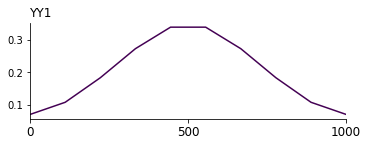

In [ ]:
ProfilePack2Visual(YY1_overpeaks, combomode = np.mean, vismode = LinePlot, bounds = (None, None), Vsize = 1000, 
            xlabelsnum = 3, labels = ['YY1'], suptitle = None, figsize = (5,2), fontsize = 12, cmap = 'viridis')

Getting histone signal (4000bp, Vsize = 4000) over the Markers using SigCurrent2Pack. 

In [ ]:
histone_norm = pickle.load(open('histone_norm' + '.p', 'rb'))

histone_overpeaks = SigCurrent2Pack(histone_norm, YY1peaks_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 4000, reso = CTReso, 
                                    newreso = None, resomode = np.mean, areas = None, exact = True, stranded = True, dtype = np.float32)
histone_overpeaks.shape

(312, 2, 40)

Averaging the total histone signal(combomode = np.mean) and visualizing with a line plot (vismode = LinePLot). 

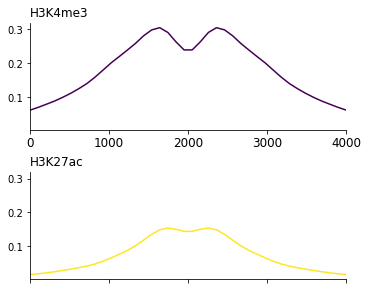

In [ ]:
ProfilePack2Visual(histone_overpeaks, combomode = np.mean, vismode = LinePlot, bounds = (None, None), Vsize = 4000, 
                   xlabelsnum = 5, labels = histones, suptitle = None, figsize = (5,4), fontsize = 12, cmap = 'viridis')

### YY1 Potential Interacting Sites

Loading and Converting CM to PWM.  
*See First_steps for pre-work*

In [ ]:
YY1_PWM = CM2PWM('YY1_CM.txt', pseudo = True, bkg = [0.25,0.25,0.25,0.25])
YY1_PWM

array([[-0.69632361,  1.27330274, -0.70974413, -1.4970148 ],
       [ 1.92165395, -7.45121111, -2.36374827, -6.45121111],
       [ 1.92816726, -7.45121111, -7.45121111, -2.45121111],
       [ 0.06448873, -0.33227004,  1.0204641 , -2.92764916],
       [ 1.99380373, -7.45121111, -7.45121111, -7.45121111],
       [-7.45121111, -7.45121111, -7.45121111,  1.99380373],
       [-7.45121111, -7.45121111,  1.99380373, -7.45121111],
       [-7.45121111, -7.45121111,  1.99380373, -7.45121111],
       [-1.72329066,  1.78001007, -7.45121111, -1.95935802],
       [-1.77878577, -0.59323012,  1.35291991, -1.02494636],
       [-1.2032836 , -0.97547768,  1.47360139, -1.83650127],
       [-1.2032836 ,  1.53178246, -1.89662226, -1.30146399]])

In [8]:
hg38, hg38_id, hg38_sizes = pickle.load(open('hg38' + '.p', 'rb')) #Loading

Scoring the PWM on the genome SeqCurrent.  
Due to memory constraints, each chr is scored seperately and saved, and each sub-seq is broken to 100 piecies before scoring operations.  
Using multiprocessing (parrellel = 4). 

In [57]:
for c in select_chrs: 
    PWMscores = PWMScorer(YY1_PWM, hg38, hg38_id, [c], parrellel = 4, pieces = 100, extend = True, center = True, dtype = np.float32)
    pickle.dump(PWMscores, open('YY1_PWMscores_' + c + '.p', 'wb')) #Saving
    del PWMscores 

Combining scores from each individual chr to a single Current. 

In [65]:
PWMscores_all = [pickle.load(open('YY1_PWMscores_' + c + '.p', 'rb'))[0] for c in select_chrs]

pickle.dump(PWMscores_all, open('YY1_PWMscores_all' + '.p', 'wb')) #Saving

#### PWM score versus binding intensity

In [6]:
YY1peaks_filt = pickle.load(open('YY1peaks_filt' + '.p', 'rb')) #Loading
PWMscores_all = pickle.load(open('YY1_PWMscores_all' + '.p', 'rb')) #Loading
YY1_norm = pickle.load(open('YY1_norm' + '.p', 'rb')) #Loading

Getting maximum PWM score at each Marker of size 500 with newreso = 500 and resomode of np.max using SigCurrent2Pack. 

In [9]:
YY1peaks_PWM = SigCurrent2Pack(PWMscores_all, YY1peaks_filt, hg38_id, select_BS_ids = select_chrs, Vsize = 500, reso = 1, 
                               newreso = 500, resomode = np.max, areas = None, exact = False, stranded = True, dtype = np.float32)
YY1peaks_PWM.shape

(156, 1, 1)

Flattening the YY1 PWM maximum score pack using PackShaper. 

In [10]:
YY1peaks_PWM_flat = PackShaper(YY1peaks_PWM, expand_dim = None, squeeze = False, twoD = False, flatten = True)
YY1peaks_PWM_flat.shape

(156,)

Finding the correlation of the best PWM score and MACS3 Peak score. 

In [11]:
cor1 = stats.pearsonr(YY1peaks_filt['add4'].values,YY1peaks_PWM_flat)[0]
print(f'Pearson correlation of Peak Score and PWM score: {np.round(cor1, 3)}')

Pearson correlation of Peak Score and PWM score: 0.426


Plotting PWM score vs. Peak Score. 

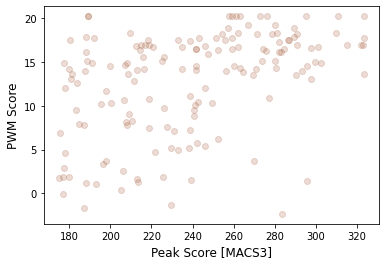

In [12]:
plt.scatter(YY1peaks_filt['add4'].values,YY1peaks_PWM_flat, alpha = 0.2, color = 'sienna');
plt.xlabel('Peak Score [MACS3]', fontsize = fontsize)
plt.ylabel('PWM Score', fontsize = fontsize);

Getting integrated YY1 signal at each Marker of size 480 with Vsize and areas of 480 using SigCurrent2Pack. 

In [13]:
YY1_overpeaks = SigCurrent2Pack(YY1_norm, YY1peaks_filt, hg38_id, select_BS_ids = select_chrs, Vsize = 480, reso = CTReso, 
                                newreso = None, resomode = np.mean, areas = [480], exact = True, stranded = True, dtype = np.float32)

Flattening the pack using PackShaper. 

In [14]:
YY1_overpeaks_flat = PackShaper(YY1_overpeaks, expand_dim = None, squeeze = False, twoD = False, flatten = True)

Finding the correlation of the best PWM score and integrated YY1 signal. 

In [15]:
cor2 = stats.pearsonr(YY1_overpeaks_flat,YY1peaks_PWM_flat)[0]
print(f'Pearson correlation of Peak Score and PWM score: {np.round(cor2, 3)}') 

Pearson correlation of Peak Score and PWM score: 0.324


Plotting PWM score vs. integrated YY1 signal. 

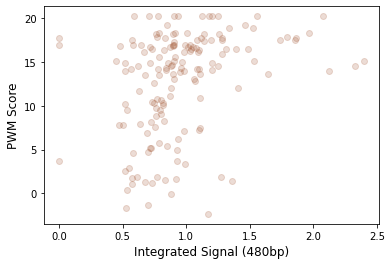

In [16]:
plt.scatter(YY1_overpeaks_flat,YY1peaks_PWM_flat, alpha = 0.2, color = 'sienna');
plt.xlabel('Integrated Signal (480bp)', fontsize = fontsize)
plt.ylabel('PWM Score', fontsize = fontsize);

#### Top PWM sites 

Getting the PWM score flags.  
Loading and modifying each chr seperately for memory constraints.  
PWM scores are first filtered using the full filter Current and multiplying with CurrentModifier.  
Currentthresholder keeps values greater than 0.  
CurrentFlagger finds best value in 200bp window with stride 20 and using double flagging.  

In [ ]:
FTE = pickle.load(open('FTE' + '.p', 'rb'))

for ic, c in enumerate(select_chrs): 
    PWMscores = pickle.load(open('YY1_PWMscores_' + c + '.p', 'rb')) #Loading
    PWMscores_filt = CurrentModifier(PWMscores, [FTE[ic]], np.multiply, dtype = np.float32)
    #PWMscores_filt = CurrentThresholder(PWMscores_filt, threshold = 0, threshsign = np.greater, binary = False) #Zeros negative values
    PWMscores_flag = CurrentFlagger(PWMscores_filt, reso = 1, window = 200, stride = 20, flagmode = np.argmax, double = True)
    pickle.dump(PWMscores_flag, open('YY1_PWMscores_flag_' + c + '.p', 'wb')) #Saving
    del PWMscores, PWMscores_filt, PWMscores_flag

In [ ]:
del [FTE] 

Combining flags from each individual chr to a single Current. 

In [ ]:
PWMscores_flags = [pickle.load(open('YY1_PWMscores_flag_' + c + '.p', 'rb'))[0] for c in select_chrs]

pickle.dump(PWMscores_flags, open('YY1_PWMscores_flags' + '.p', 'wb')) #Saving

Plotting Histogram of non-zero PWM flags. 

In [ ]:
#PWMscores_flags = pickle.load(open('YY1_PWMscores_flags' + '.p', 'rb')) #Loading

flag_values = np.concatenate(PWMscores_flags, axis = 0) #Combining all flag values together for next step

plt.hist(flag_values[flag_values != 0], bins = 100, histtype='step', color = 'sienna');
#plt.title('Cumulative PWM Scores', fontsize = fontsize) 
plt.xlabel('PWM Score', fontsize = fontsize) 
plt.ylabel('Counts', fontsize = fontsize);

In [ ]:
del [flag_values]

Testing different SigCurrent2Markers modes

In [ ]:
#PWMscores_flags = pickle.load(open('YY1_PWMscores_flags' + '.p', 'rb')) #Loading

MO = [None, Top, Harpoon, Harpoon, RevDistro, RevDistro, RevDistro, RevDistro]
MA = [None, {'smallest': False}, {'bins': 10}, {'bins': 100}, {'alpha': 0}, {'alpha': 0.5}, {'alpha': 1.0}, {'alpha': 2.0}]

vals = [] 
for im in range(len(MO)): 
    M = SigCurrent2Markers(PWMscores_flags, hg38_id, select_BS_ids = select_chrs, reso = 1, select = 1000, select_mode = MO[im], mode_args = MA[im])
    vals.append(M['val'])

In [ ]:
allflags = np.concatenate(PWMscores_flags, axis = 0).reshape(-1)
mi, ma = np.min(allflags), np.max(allflags)
bs = np.linspace(mi, ma, 100)

del allflags

Plotting Markers values for different SigCurrent2Markers modes 

In [ ]:
fontsize = 12

sel_modes_names = ['None, None', 'Top, smallest = False', 'Harpoon, bins = 10', 'Harpoon, bins = 100', 
                   'RevDistro, alpha = 0', 'RevDistro, alpha = 0.5', 'RevDistro, alpha = 1.0', 'RevDistro, alpha = 2.0'] 

fig, axs = plt.subplots(2, 4, figsize = (16,10), sharey = True)

for (iv, v), ax in zip(enumerate(vals), axs.ravel()):
    if iv == 0: 
        ax.set_xlabel('PWM Score, 100 bins', fontsize = fontsize)
        ax.set_ylabel('Counts', fontsize = fontsize)
    ax.hist(v, bs, color = 'sienna')
    ax.set_title(sel_modes_names[iv], fontsize = fontsize)

Getting 100,000 Marks from PWM flags with Harpoon (bin = 100) for preparing packs for ML (next step) with SigCurrent2Markers. 

In [ ]:
#PWMscores_flags = pickle.load(open('YY1_PWMscores_flags' + '.p', 'rb')) #Loading

PWMscores_harpoon = SigCurrent2Markers(PWMscores_flags, hg38_id, select_BS_ids = select_chrs, reso = 1, select = 1000, select_mode = Harpoon, mode_args = {'bins': 100})

pickle.dump(PWMscores_harpoon, open('YY1_PWMscores_harpoon' + '.p', 'wb'))

PWMscores_harpoon

In [ ]:
del [PWMscores_flags] 

### Packs for ML 

Generating Packs for ML using the Harpoon'ed Markers

In [ ]:
hg38, hg38_id, hg38_sizes = pickle.load(open('hg38' + '.p', 'rb')) #Loading

PWMscores_harpoon = pickle.load(open('YY1_PWMscores_harpoon' + '.p', 'rb')) #loading 
YY1_norm = pickle.load(open('YY1_norm' + '.p', 'rb')) #Loading
histone_norm = pickle.load(open('histone_norm' + '.p', 'rb')) #Loading

Modifying Markers to be used for pack generation (next steps). Both strands are used (opposite = True) and no marker in the ends of 5000bp. 

In [ ]:
PWMscores_ready = Markers4Packs(PWMscores_harpoon, select_BS_ids = None, opposite = True, 
                                 ends = 5000, BS_sizes = hg38_sizes, BS_ids = hg38_id)

Integrated YY1 signal of 480bp over Markers. 

In [ ]:
YY1pack = SigCurrent2Pack(YY1_norm, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 480, reso = CTreso, 
                          newreso = None, resomode = np.mean, areas = [480], exact = True, stranded = True, dtype = np.float32)

Flattening pack, likely to be used for Sklearn. 

In [ ]:
YY1pack_flat = PackShaper(YY1pack, expand_dim = None, squeeze = False, twoD = False, flatten = True)

Histone signal of 4000bp over Markers. 

In [ ]:
histonepack_profile = SigCurrent2Pack(histone_norm, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 4000, reso = CTreso, 
                                      newreso = 100, resomode = np.mean, areas = None, exact = True, stranded = True, dtype = np.float32)

print(f'Histone ProfilePack shape: {histonepack_profile.shape}')

Integrated Histone signals (4) with maximum of 4000bp over Markers. 

In [ ]:
areas = np.geomspace(500,4000,4, dtype = int) #Getting different 4 areas from 500 to 4000bp geometrically. 
histonepack_areas= SigCurrent2Pack(histone_norm, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 4000, reso = CTreso, 
                                   newreso = None, resomode = np.mean, areas = areas, exact = True, stranded = True, dtype = np.float32)

print(f'Histone AreasPack shape: {histonepack_areas.shape}')

Also getting the best PWM score over each Marker with Traits2Pack. 

In [ ]:
PWMscore_pack = Traits2Pack(PWMscores_ready, cols = 4, vectorize = None)
PWMscore_pack.shape

Getting sequences underlying Markers of size 500, stranded (stranded = True) with SeqCurrent2Pack. 

In [ ]:
seq_pack = SeqCurrent2Pack(hg38, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 500, seqmode = None, stranded = True)

Getting sequences underlying Markers of size 500, stranded (stranded = True), and OHE (seqmode = Seqs2OHE) with SeqCurrent2Pack. 

In [ ]:
seq_pack_OHE = SeqCurrent2Pack(hg38, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 500, seqmode = Seqs2OHE, stranded = True)
seq_pack_OHE.shape

Combinations of packs can be done with Packs2Pack([Packs]) 

#### Splitting Packs

Splits for ML are generated using Splits and the Markers.  
3 Splits are generated (numsplits = 3) with simple Train Test split of 0.7 and 0.3 proportions, respecively (proportions = [0.7,0.3]).  
The cut method is applied (cut = True) 

In [ ]:
YY1sites_split = Splitter(len(PWMscores_ready), numsplits = 3, proportions = [0.7, 0.3], random = False, cut = True)


YY1sites_split[0]

Splitting a pack by a split can be done with PackSplit(Pack, YY1sites_split[n])